File "AQM_Analyse":
1. Import the clean Data from SQL DB into Notebook
2. Prepare Data for Analysis
3. Create Dataframe to save the Results
4. Create Loop, which executes multivariate OLS regressions using all combinations of 1 and 10 explanatory macroeconomic variables 
5. Save the Results from the Loop into the "Result"-Dataframe
    For each Regression calculate:
        Autocorrelation
        heteroskedasticity
        multicollinearity
6. Export Results to SQL Lite into Table "Results"

In [38]:
import math
from math import exp, sqrt, log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy
import xlsxwriter

from scipy import stats
import pylab
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson

import sqlite3
from sqlite3 import Error
 
""" create a database connection tool to a SQLite database """
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")


2.6.0


In [39]:
#Select Statement to import the SQL Data back into Python:   
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute("SELECT * FROM MACRO_CLEAN")
macro_sql_data=c.fetchall()
macro = pd.DataFrame(macro_sql_data,columns=['DATE', 'Macro_Variable',  'Value'])
macro = macro.set_index('DATE')
macro = macro.pivot(columns='Macro_Variable', values=['Value'])
macro = macro.droplevel(level=0, axis=1)

c.execute("SELECT * FROM FUTURES_CLEAN")
futures_sql_data=c.fetchall()
futures = pd.DataFrame(futures_sql_data,columns=['DATE', 'CLOSE', 'Instrument', 'Return'])
futures = futures.set_index('DATE')
futures = futures.pivot(columns='Instrument', values=['Return']) 
futures = futures.droplevel(level=0, axis=1)

In [40]:
macro.head(5)

Macro_Variable,CHCPIY_ECI,CHJOB_ECI,CHPMI_ECI,CNCPI_ECI,CNPMIB_ECI,EUHICY_ECI,EUUNR_ECI,RUCPIY_ECI,RUUNR_ECI,USCPI_ECI,USPMI_ECI,USUNR_ECI
DATE,,,,,,,,,,,,
2012-01-31,-0.8,2.8,48.0,4.5,50.5,2.7,10.9,4.2,6.3,0.3,54.2,8.3
2012-02-29,-0.9,2.8,48.2,3.2,51.0,2.7,11.1,3.7,6.2,0.2,53.3,8.3
2012-03-31,-1.0,2.8,50.6,3.6,53.1,2.7,11.2,3.7,6.3,0.2,53.5,8.2
2012-04-30,-1.0,2.8,46.5,3.4,53.3,2.6,11.3,3.6,5.6,0.2,55.2,8.2
2012-05-31,-1.0,2.9,45.8,3.0,50.4,2.4,11.4,3.6,5.2,-0.2,53.2,8.2


In [41]:
futures.head(5)

Instrument,CLc1,Cc1,GCc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
DATE,,,,,,,,,,,
2012-01-31,-0.003548,-0.011669,0.104223,0.015742,0.035098,-0.177449,0.217209,0.045254,0.124642,0.175813,0.020095
2012-02-29,0.083629,0.027018,-0.016185,0.022179,0.054151,0.044156,-0.097193,0.029731,0.064479,0.039819,-0.002631
2012-03-31,-0.038560,-0.019224,-0.024031,-0.058057,0.035080,-0.207404,-0.147004,-0.078729,-0.031720,-0.063076,-0.005283
2012-04-30,0.017798,0.024920,-0.003541,-0.014214,-0.060838,0.072124,-0.155215,0.042856,-0.044050,-0.047622,-0.019871
2012-05-31,-0.192230,-0.173200,-0.062513,-0.013992,-0.069586,0.058228,-0.228750,-0.107767,-0.101703,-0.109752,-0.006194


Test for Stationarity with Dickey Fuller Test / Unit Root

In [ ]:
#tickers_loop="WIKI/" + data_4['ticker'][0:20] + " - Open"
tickers_loop=futures
tickers_loop_list=list(tickers_loop.iloc[:].values)
var_list=tickers_loop_list

In [ ]:
for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Prices (Level)')
    for i in var_list:
        adf_library = adfuller(futures[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(futures[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library[1],)
    print('____________________________________________','\n')

In [ ]:
for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Absolute Returns (1st Difference)')
    for i in var_list:
        adf_library = adfuller(data_3[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(data_3[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library_d[1])
    print('____________________________________________','\n')

In [ ]:
#Code for VIF Calculation - added a Return-Statement, so that the Results get added in a DataFrame:
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    ttt = pd.DataFrame()
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(formula="y~x", data=x_vars,endog=y, exog=x).fit().rsquared  
        vif=round(1/(1-rsq),2)

        tt = pd.DataFrame()
        tt['XVAR'] = [xvar_names[i]]
        tt['VIF'] = [vif]
        ttt = ttt.append(tt)
    return ttt

In [ ]:
#VIF Calc: Code for 1 column:
input_columns = macro[['CHCPIY_ECI','CHJOB_ECI','CHPMI_ECI','CNCPI_ECI','CNPMIB_ECI','EUHICY_ECI','EUUNR_ECI','RUCPIY_ECI','RUUNR_ECI','USCPI_ECI','USPMI_ECI','USUNR_ECI']]
xxx = vif_cal(input_data=input_columns, dependent_col='CHCPIY_ECI')
xxx

In [ ]:
#VIF Calc: Code for all Columns - Loop:
input_columns = macro[['CHCPIY_ECI','CHJOB_ECI','CHPMI_ECI','CNCPI_ECI','CNPMIB_ECI','EUHICY_ECI','EUUNR_ECI','RUCPIY_ECI','RUUNR_ECI','USCPI_ECI','USPMI_ECI','USUNR_ECI']]
VIF_Results = pd.DataFrame()
for col in range(0, len(input_columns.columns)):
    vif = vif_cal(input_data=input_columns, dependent_col=input_columns.columns[col])
    vif = pd.DataFrame(vif)
    vif['dep_col'] = input_columns.columns[col]
    VIF_Results = VIF_Results.append(vif)
VIF_Results = VIF_Results.set_index(['dep_col']).pivot(columns='XVAR', values=['VIF'])
VIF_Results = VIF_Results.droplevel(level=0, axis=1)
VIF_Results.to_excel('VIF_Results.xlsx')
VIF_Results

Normality Test: Jarque Bera

In [ ]:
#Jarque Bera Test of the futures:


#to_excel('Results_futures_JB.xlsx')

In [ ]:
#Jarque Bera Test of the Macro:


#to_excel('Results_macro_JB.xlsx')

OLS

In [ ]:
#OLS
import statsmodels.api as sm
y = futures['CLc1']
x = macro[['CHCPIY_ECI','CHJOB_ECI','CHPMI_ECI','CNCPI_ECI','CNPMIB_ECI','EUHICY_ECI','EUUNR_ECI','RUCPIY_ECI','RUUNR_ECI','USCPI_ECI','USPMI_ECI','USUNR_ECI']]
x = sm.add_constant(x)
model = sm.OLS(y,x, missing = 'drop') 
results = model.fit(cov_type='HAC', cov_kwds={'maxlags':1})
#print(results.summary())

Loop:

                            OLS Regression Results                            
Dep. Variable:                   CLc1   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     7.697
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           3.96e-10
Time:                        17:35:15   Log-Likelihood:                 107.58
No. Observations:                 120   AIC:                            -189.2
Df Residuals:                     107   BIC:                            -152.9
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7708      0.420      1.836      0.0

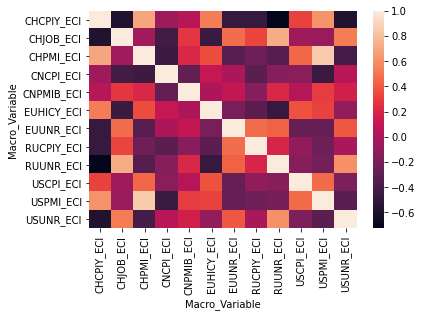

In [42]:
#Create Table to save all Results from OLS:
import statsmodels.api as sm
Results_OLS = pd.DataFrame()
Top_results_OLS = pd.DataFrame()
VIF_Results = pd.DataFrame()
Breusch_Pagan = pd.DataFrame()

len_comm_col = len(futures.columns) 
for col in range(0, len_comm_col):
    
    #OLS Simulation for each Commodity:
    y = futures[futures.columns[col]]
    x = macro[['CHCPIY_ECI','CHJOB_ECI','CHPMI_ECI','CNCPI_ECI','CNPMIB_ECI','EUHICY_ECI','EUUNR_ECI','RUCPIY_ECI','RUUNR_ECI','USCPI_ECI','USPMI_ECI','USUNR_ECI']]
    x = sm.add_constant(x)
    model = sm.OLS(y,x, missing = 'drop') 
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags':1})
    print(results.summary())

    # Breush Pagan Test for Heteroskedastic residuals
    regression1 = pd.DataFrame(y)
    prediction = results.predict()
    regression1['Prediction'] = prediction
    residuals1 = y - prediction
    results_summary  = results.summary()
    #plt.plot(residuals1)
    #plt.title('Residuals')
    #plt.show

    pagan = pd.DataFrame()
    name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    pagan = sms.het_breuschpagan(residuals1, results.model.exog)
    breusch = lzip(name, pagan)
    breusch = pd.DataFrame(breusch)
    breusch['Commodity'] = futures.columns[col]
    Breusch_Pagan = Breusch_Pagan.append(breusch)
    Breusch_Pagan

    #Append Results to the Results-Table:
    results_as_html = results_summary.tables[1].as_html()
    results = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results['Commodity'] = futures.columns[col]
    Results_OLS = Results_OLS.append(results)
    dfs = {}
    fs = results_summary
    for item in fs.tables[0].data:
        dfs[item[0].strip()] = item[1].strip()
        dfs[item[2].strip()] = item[3].strip()
    for item in fs.tables[2].data:
        dfs[item[0].strip()] = item[1].strip()
        dfs[item[2].strip()] = item[3].strip()
    dfs = pd.Series(dfs)
    dfs = pd.DataFrame(dfs)
    dfs.reset_index()
    dfs['Commodity'] = futures.columns[col]
    Top_results_OLS = Top_results_OLS.append(dfs)
    Top_results_OLS

Results_OLS.to_excel('OLS_Results_Bottom.xlsx')
Top_results_OLS = Top_results_OLS.pivot(columns='Commodity', values=[0])
Top_results_OLS = Top_results_OLS.droplevel(level=0, axis=1)
Top_results_OLS.to_excel('OLS_Results_Top.xlsx')
Breusch_Pagan = Breusch_Pagan.rename(columns={0:'Variable', 1:'Value'})
Breusch_Pagan = Breusch_Pagan.set_index('Variable')
Breusch_Pagan = Breusch_Pagan.pivot(columns='Commodity', values=['Value'])
Breusch_Pagan = Breusch_Pagan.droplevel(level=0, axis=1)
Breusch_Pagan.to_excel('Breusch_Pagan_Results.xlsx')

#print Correlation Matrix -> braucht kein Loop, da überall immer das Gleiche:
corr = macro[['CHCPIY_ECI','CHJOB_ECI','CHPMI_ECI','CNCPI_ECI','CNPMIB_ECI','EUHICY_ECI','EUUNR_ECI','RUCPIY_ECI','RUUNR_ECI','USCPI_ECI','USPMI_ECI','USUNR_ECI']].corr()
corr.to_excel('Correlation_Matrix.xlsx')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values);


In [ ]:
Results_OLS

In [ ]:
Top_results_OLS

Diverse Code-Snippets:

In [ ]:
#Jarq Bera Test:
stats.jarque_bera(ReturnS)

#LjungBox autocorrelation:
PF_Ljung = sm.stats.acorr_ljungbox(PF_Returns, lags=10)

#Autocorrelation als Grafik:
data = np.array(PF_Returns)
plt.acorr(data, maxlags=20)
plt.title('Autokorrelation der Portfolio-Renditen')
plt.xlabel('Lag')
plt.ylabel('Autokorrelation')
plt.savefig('Autocorrelation.png', dpi=800)
plt.show()



#ad Fuller
ts.adfuller(df['GDP'])



#Breusch Pagan Test:
statsmodels.stats.diagnostic.het_breuschpagan(results.resid, exog_het = x)




np.dot(var1,var2) vector multiplication

var1.T transposes the vector

np.linalg.inv (var1) inverts the matrix

np.diag (var1) extract a diagonal

Def fct (var1,var2) defines the function ,

OLS_results = library for displaying further

Return OLS_results


df = pd.DataFrame(np.random.randint(low=0, high=10, size=(5, 5)), 
                  columns=['Historic_Rate', 'Overnight', '1M', '3M', '6M'])

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in df.columns if x != 'Historic_Rate']:
    Y = df['Historic_Rate'] - df['Historic_Rate'].shift(1)
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = df[col] - df[col].shift(1)
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()

Beispiel Loops:

In [ ]:
#---------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------
#Parameter definieren:
#---------------------------------------------------------------------------------------------------------------
Anzahl_Simulationen = 1000 #1000, 2000, 3000 Simulationen eingeben
Sample_length = 750 #Sample-Grösse für Bootstrap: 250, 500, 750, 1000
alpha = 0.05 #Konfidenzintervall definieren 0.05 und 0.25
Position_VaR = int(Anzahl_Simulationen * alpha) 
#Da unterschiedliche Anzahl Simulationen, dynamisch 5%-Position 
Anzahl_Wiederholungen = 5   
#Konsistenz der Berechnung überprüfen, indem alles 5-Mal durchgeführt wird.


#---------------------------------------------------------------------------------------------------------------
#Sample-Länge definieren:
#Automatische Adjustierung der Sample-Länge:
#---------------------------------------------------------------------------------------------------------------
Returns2 = Returns.reset_index()
Sample_for_Bootstrap = Returns2[['Novartis', 'LafargeHolcim',
                                 'Logitech', 'Nestle', 'Swiss_Re']]

sample_length_adjustierung = (round((len(Sample_for_Bootstrap)-Sample_length)/(10)))*10 + Sample_length
Returns_for_sample = Returns[:sample_length_adjustierung].reset_index()
Sample_for_Bootstrap = Returns_for_sample[['Novartis', 'LafargeHolcim',
                                           'Logitech', 'Nestle', 'Swiss_Re']]

#---------------------------------------------------------------------------------------------------------------
#Loop 1: Alles 5 Mal ausführen und als Excel & Grafik speichern:
#---------------------------------------------------------------------------------------------------------------
for y in range(0,Anzahl_Wiederholungen):
    BHS = [] #Tabelle mit allen berechneten VaR der BHS-Methode
    CBB = [] #Tabelle mit allen berechneten VaR der CBB-Methode
    Reality = [] #Tabelle für die jeweiligen 10 Tage, welche für das Backtesting benötigt werden
    
    #Dynamisch die Dateinamen für das Excel und der Grafik generieren:
    excel_name = "Simulationen/VaR_Simulation_"+str(alpha)+"_Sim_"+str(Anzahl_Simulationen)+"_length_"+str(Sample_length)+"_V"+str(y+1)+ ".xlsx"
    Bild_name = "Simulationen/VaR_Simulation_"+str(alpha)+"_Sim_"+str(Anzahl_Simulationen)+"_length_"+str(Sample_length)+"_V"+str(y+1)+".png"
    
    #---------------------------------------------------------------------------------------------------------------
    #Loop 2: Rolling-Window-Methode: 750 Tage für die Durchführung des Bootstrappings + 10 Tage für Backtesting:
    #---------------------------------------------------------------------------------------------------------------
    for x in range(0, len(Sample_for_Bootstrap)-Sample_length, 10): 
        Samp = Sample_for_Bootstrap[x:x+Sample_length] 

        #Nächsten 10 Tagen für das Backtesting wählen, in diskrete Portfolio-Renditen umrechnen und speichern:
        T = Sample_for_Bootstrap.iloc[x+Sample_length:x+Sample_length+10]
        Real_Sample = T.sum()
        diskrete_real = Math.e**(Real_Sample)-1 
        diskrete_real = diskrete_real.mean()  
        Reality.append(diskrete_real)
        
        #---------------------------------------------------------------------------------------------------------------
        #Loop 3: 
            #Bootstrap Historical Simulation & Circular Bootstrap anwenden
            #mit n Simulationen & zeitliche Addition der Log-Returns 
            #umrechnen in diskrete Returns und berechnung Mittelwert für Portfolio-Rendite:
        #---------------------------------------------------------------------------------------------------------------

        #---------------------------------------------------------------------------------------------------------------
        #Bootstrap Historical Simulation (BHS): 10 Tage nach Zufall mit Zurücklegen ziehen und dies 1000 mal wiederholen:
        #---------------------------------------------------------------------------------------------------------------
        BHS_VaR = []
        for x in range(0,Anzahl_Simulationen):
            Stichproben = Samp.sample(n=10, replace=True).sum()
            df2 = Math.e**(Stichproben)-1 
            x = df2.mean() 
            BHS_VaR.append([x])   

        #---------------------------------------------------------------------------------------------------------------
        #Circular Block Bootstrap (CBB): 10-Tages-Blöcke mit Circular-Effekt ziehen und dies 1000 mal wiederholen:
        #---------------------------------------------------------------------------------------------------------------
        CBB_VaR = [] 
        for x in range(0,Anzahl_Simulationen):    
            Random_X_from = np.random.randint(0,Sample_length+1)
            Random_X_to = Random_X_from + 10
            Stichproben_CBB = Samp[Random_X_from:Random_X_to]
            
            #-------------------------------------------------------------------------
            #Circular-Effekt: Das Ende des Samples mit dem Anfang verbinden -> über den Rand
            #-------------------------------------------------------------------------
            if Random_X_to > Sample_length: #Überprüfen, ob Block über den Rand geht.
                Random_X_to_Circle = (Random_X_to-Sample_length) #Anzahl fehlende Tage berechnen
                Rest_Circular = Samp[:Random_X_to_Circle] #Fehlende Tage vom Anfang des Samples holen
                Stichproben_CBB = pd.concat([Stichproben_CBB, Rest_Circular]) #Beide Listen zusammenfügen

            Stichproben_CBB.sum()
            Stichproben_CBB = Stichproben_CBB.sum()
            df_CBB = Math.e**(Stichproben_CBB)-1  #Log Renditen in Diskrete Renditen umrechnen
            x_CBB = df_CBB.mean()    #Portfolio Rendite rechnen
            CBB_VaR.append([x_CBB])    #Tabelle mit 1000 Portfolio Renditen

        #---------------------------------------------------------------------------------------------------------------
        #Alle 1000 simulierten Portfolio-Renditen aufsteigend sortieren und der 51 schlechteste als VaR definieren:
        #---------------------------------------------------------------------------------------------------------------
        CBB_VaR.sort()
        PF_Returns_Simulation_CBB = pd.DataFrame(CBB_VaR)
        VaR_CBB = PF_Returns_Simulation_CBB.iloc[Position_VaR]
        CBB.append(VaR_CBB)

        BHS_VaR.sort()
        PF_Returns_Simulation_BHS = pd.DataFrame(BHS_VaR)
        a = PF_Returns_Simulation_BHS.iloc[Position_VaR]
        BHS.append(a)
    
    #---------------------------------------------------------------------------------------------------------------
    #Die berechneten VaRs der beiden Methoden in neue Tabelle speichern & die tatsächliche 10-Tages-Rendite ergänzen:
    #---------------------------------------------------------------------------------------------------------------
    Simulationen = pd.DataFrame(BHS)
    Simulationen = Simulationen.rename(columns={0:'BHS_VaR'})
    Simulationen['CBB_VaR'] = pd.DataFrame(CBB)
    Simulationen = Simulationen.reset_index()
    Simulationen.drop('index', axis=1, inplace=True)
    Simulationen = pd.concat([Simulationen, pd.DataFrame(Reality)], axis=1)
    Simulationen = Simulationen.rename(columns={0:'Reality'})
    
    #---------------------------------------------------------------------------------------------------------------
    #Grafik speichern:
    #---------------------------------------------------------------------------------------------------------------
    Simulationen.plot(figsize=(30,15));
    plt.savefig(Bild_name, dpi=400)
    
    #---------------------------------------------------------------------------------------------------------------
    #Anzahl Exceptions & Exceptions Rate berechnen:
    #---------------------------------------------------------------------------------------------------------------  
    Simulationen['BHS_Exceptions'] = Simulationen.BHS_VaR > Simulationen.Reality
    Simulationen['Anzahl_BHS_Exceptions'] = (Simulationen.BHS_VaR > Simulationen['Reality']).sum()
    Simulationen['BHS_Exception_Rate'] = Simulationen.Anzahl_BHS_Exceptions/(len(Simulationen))
    
    Simulationen['CBB_Exceptions'] = Simulationen.CBB_VaR > Simulationen.Reality
    Simulationen['Anzahl_CBB_Exceptions'] = (Simulationen.CBB_VaR > Simulationen['Reality']).sum()
    Simulationen['CBB_Exception_Rate'] = Simulationen.Anzahl_CBB_Exceptions/(len(Simulationen))
    
    Simulationen.to_excel(excel_name)
    Simulationen

In [ ]:
#-----------------------------------------------------------------------------------------------
#Abgelegte Excels für das Backtesting einlesen:
#-----------------------------------------------------------------------------------------------
Sim = [1000, 2000, 3000]
LL = [250, 500, 750, 1000]
Anzahl_Wiederholungen = 5
path = r'C:\Users\lione\OneDrive\ZHAW\Bachelor-Arbeit\Simulationen'

#-----------------------------------------------------------------------------------------------
#Parameter eingeben: 
#-----------------------------------------------------------------------------------------------
Hypo_alpha = 0.05  #Konfidenzniveau für Hypothesen-Test eingeben !!!!!!!!!!!! 0.25????

#-----------------------------------------------------------------------------------------------
#Abgelegte Excels für das Backtesting mittels Schlaufen einlesen:
#-----------------------------------------------------------------------------------------------
Results = pd.DataFrame()

for S in Sim:
    for L in LL:
        for y in range(0,Anzahl_Wiederholungen):
            
            #-----------------------------------------------------------------------------------------------
            #Alle Excel-Files importieren und als DataFrames speichern:
            #-----------------------------------------------------------------------------------------------
            excel_name = "\VaR_Simulation_Sim_"+str(S)+"_length_"+str(L)+"_V"+str(y+1)+".xlsx" #VaR 95%
            import_name = path + excel_name
            name = "S_"+str(S)+"_L_"+str(L)+"_V"+str(y+1)
            vars()[name] = pd.read_excel(import_name, sep=';', index_col=0).sort_index()
            
            #-----------------------------------------------------------------------------------------------
            #RUNS-TEST:
            #Für jedes File den Runs-Test durchführen und den Z-Score und P-Wert speichern:
            #-----------------------------------------------------------------------------------------------
            vars()[name]['RT_Z_Score_BHS'] = runstest_1samp(vars()[name].BHS_Exceptions, correction=False)[0]
            vars()[name]['RT_P_Value_BHS'] = runstest_1samp(vars()[name].BHS_Exceptions, correction=False)[1]
            vars()[name]['RT_reject_H0_BHS'] = vars()[name]['RT_P_Value_BHS'] <= Hypo_alpha
            
            vars()[name]['RT_Z_Score_CBB'] = runstest_1samp(vars()[name].CBB_Exceptions, correction=False)[0]
            vars()[name]['RT_P_Value_CBB'] = runstest_1samp(vars()[name].CBB_Exceptions, correction=False)[1]
            vars()[name]['RT_reject_H0_CBB'] = vars()[name]['RT_P_Value_CBB'] <= Hypo_alpha
            vars()[name]['Run'] = name
            
            #-----------------------------------------------------------------------------------------------
            #Erste Zeile jedes DataFrames wählen und in neue Tabelle mit allen Resultaten speichern:
            #-----------------------------------------------------------------------------------------------
            First_col = pd.DataFrame(vars()[name].iloc[0])
            First_col = First_col.T
            Results = pd.concat([Results, First_col])

#-----------------------------------------------------------------------------------------------
#Tabelle mit den Resultaten optimieren und als Excel exportieren:
#-----------------------------------------------------------------------------------------------
Results = Results.set_index('Run')
Results = Results.drop(['BHS_VaR','CBB_VaR','Reality','BHS_Exceptions', 'CBB_Exceptions'], axis=1)
Results = Results.rename(columns= 
                             {'Anzahl_BHS_Exceptions' : 'BHS_Exceptions'
                             ,'Anzahl_CBB_Exceptions' : 'CBB_Exceptions'})
Results['Anzahl_Tests'] = Results.BHS_Exceptions / Results.BHS_Exception_Rate
Results.to_excel('Results_95.xlsx')
Results_95 = Results 
Results_95